In [4]:
%matplotlib inline
import lynx
lk = lynx.LynxKite(address='http://localhost:2200/')
import pandas
import matplotlib.pyplot as plt
import random

In [5]:
partition1 = 400
partition2 = 600

completeBipartiteEdges = (lk.new_project()
.derivescalar(output = 'partition1', type = 'double', expr = str(partition2))
.derivescalar(output = 'partition2', type = 'double', expr = str(partition1))
.newvertexset(size = partition1 * partition2)
.vertexattributetodouble(attr = 'ordinal')
.derivedvertexattribute(output = 'src', type = 'string', expr = 'Math.floor(ordinal / partition1)')
.derivedvertexattribute(output = 'dst', type = 'string', expr = '(ordinal % partition1) + partition2'))
t = completeBipartiteEdges.sql('select * from vertices').to_table()

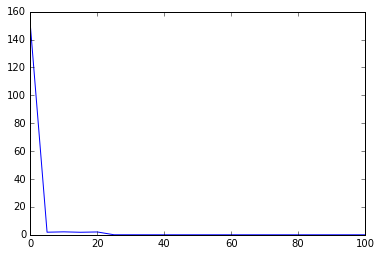

In [13]:
random.seed(15)
def error_with_forget_fraction(i):
    graph = (lk.new_project().importverticesandedgesfromasingletable(table = t.name, src = 'src', dst = 'dst')
    .derivescalar(output = 'partition2', type = 'double', expr = str(partition1))
    .derivedvertexattribute(output = 'truePartition', type = 'double', expr = 'stringID < partition2 ? 1.0 : -1.0')
    .addgaussianvertexattribute(name = 'a', seed = '13')
    .derivedvertexattribute(output = 'partition', type = 'double', expr = 'a < -0.7 ? undefined : truePartition')
    .trainneuralnetworkanduseittopredictanattribute(
        label = "partition",
        output = "prediction",
        features = "!unset",
        networkSize = "4",
        learningRate = "0.02",
        radius = "3",
        hideState = "false",
        forgetFraction = str(i),
        trainingRadius = "1",
        maxTrainingVertices = "9",
        minTrainingVertices = "7",
        iterationsInTraining = "50",
        subgraphsInTraining = "10",
        knownLabelWeight = "0.5",
        numberOfTrainings = "10",
        seed = str(random.randint(0,10000000)))
    .derivedvertexattribute(output = 'isWrong', type = 'double',
                        expr = 'var p = prediction < 0 ? -1 : 1; p === truePartition ? 0.0 : 1.0;')
    .derivedvertexattribute(output = 'differenceSquare', type = 'double',
                        expr = '(truePartition - prediction) * (truePartition - prediction)')
    .aggregatevertexattributeglobally(prefix = '', **{'aggregate-differenceSquare': 'sum'}))
    return graph.scalar('differenceSquare_sum')

number_of_examples = 3
r = range(0,101,5)
errors = []
for i in r:
    temporary_errors = []
    for j in range(number_of_examples):
        temporary_errors.append(float(error_with_forget_fraction(i / 100)))
    errors.append(sum(temporary_errors) / number_of_examples)
plt.plot(r, errors)